# **Phase 2 - Milestone 2**

**Ediashta Revindra Amirussalam**
<br>FTDS-020-RMT

## Objective

## 00 - Import Libraries

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import os
import glob
import random

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Activation, Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Rescaling
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## 01 - Data Loading

In [7]:
main_path = ('./datasets/')
os.listdir(main_path)

['test', 'train']

In [8]:
train_dir = os.path.join(main_path, 'train')
test_dir = os.path.join(main_path, 'test')
os.listdir(train_dir)

['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

In [9]:
def check_dir(dir=None, labels=None):
  i=0
  for label in labels:
    num_data= len(os.listdir(os.path.join(dir, label)))
    print(f'Data', label, ' :', num_data)
    i+= num_data
  print('Total Data :', i)
    


In [10]:
print('train set: \n' + '='*50)
check_dir(train_dir,os.listdir(train_dir))
print('\ntest set: \n' + '='*50)
check_dir(test_dir,os.listdir(test_dir))

train set: 
Data angry  : 3995
Data disgusted  : 436
Data fearful  : 4097
Data happy  : 7215
Data neutral  : 4965
Data sad  : 4830
Data surprised  : 3171
Total Data : 28709

test set: 
Data angry  : 958
Data disgusted  : 111
Data fearful  : 1024
Data happy  : 1774
Data neutral  : 1233
Data sad  : 1247
Data surprised  : 831
Total Data : 7178


## 02 - EDA & Preprocessing

### Display Sample Image

(48, 48)


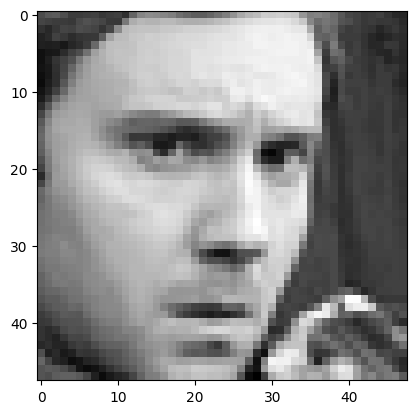

In [11]:
img = plt.imread('./datasets/train/angry/im0.png')
print(img.shape)
plt.imshow(img, cmap="gray")

In [12]:
def random_sample(image_files, num_samples=5):
  random_files= random.sample(image_files, num_samples)
  return random_files

In [13]:
def visualize_img(random_data, fig, axes, loc, labels=None):
  for i, image_path in enumerate(random_data):
    image= plt.imread(image_path)
    axes[loc, i].imshow(image, cmap='gray') # bisa tanpa cmap kalau bener2 RGB
    axes[loc, i].set_title(f'{labels}, {image.shape}')
    axes[loc, i].axis('off')

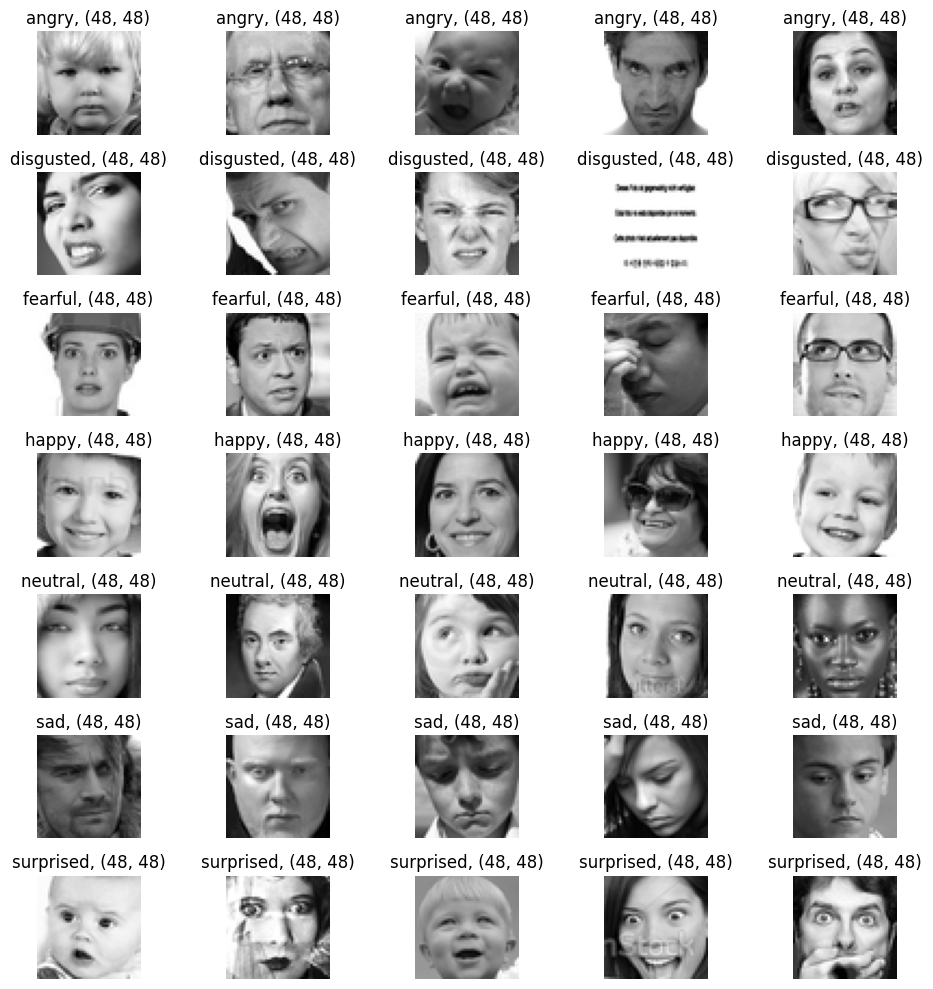

In [14]:
count = 0
fig, axes= plt.subplots(7,5, figsize=(10,10))

for i in os.listdir(train_dir):
    visualize_img(
        random_sample(
            glob.glob(f'{train_dir}/{i}/*.png')
        ), fig, axes, count, i
    )
    count+=1

plt.tight_layout()
plt.show()

### Preprocessing

In [15]:
class_labels  = [class_name.capitalize() for class_name in os.listdir(train_dir)]
img_height = 48
img_width = 48
batch_size = 64

In [16]:
preprocess_fun = tf.keras.applications.densenet.preprocess_input

train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.05,
                                   rescale = 1./255,
                                   validation_split = 0.2,
                                   preprocessing_function=preprocess_fun
                                  )
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2,
                                  preprocessing_function=preprocess_fun)

train_ds = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (img_height ,img_width),
                                                    batch_size = batch_size,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    subset = "training",
                                                    seed = 12
                                                   )

val_ds = test_datagen.flow_from_directory(directory = train_dir,
                                                         target_size = (img_height ,img_width),
                                                         batch_size = batch_size,
                                                         shuffle  = True , 
                                                         color_mode = "rgb",
                                                         class_mode = "categorical",
                                                         subset = "validation",
                                                         seed = 12
                                                        )

test_ds = test_datagen.flow_from_directory(directory = test_dir,
                                                   target_size = (img_height ,img_width),
                                                    batch_size = batch_size,
                                                    shuffle  = False , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [17]:
for image_batch , label_batch in train_ds:
  print(image_batch.shape)
  print(label_batch.shape)
  break

(64, 48, 48, 3)
(64, 7)


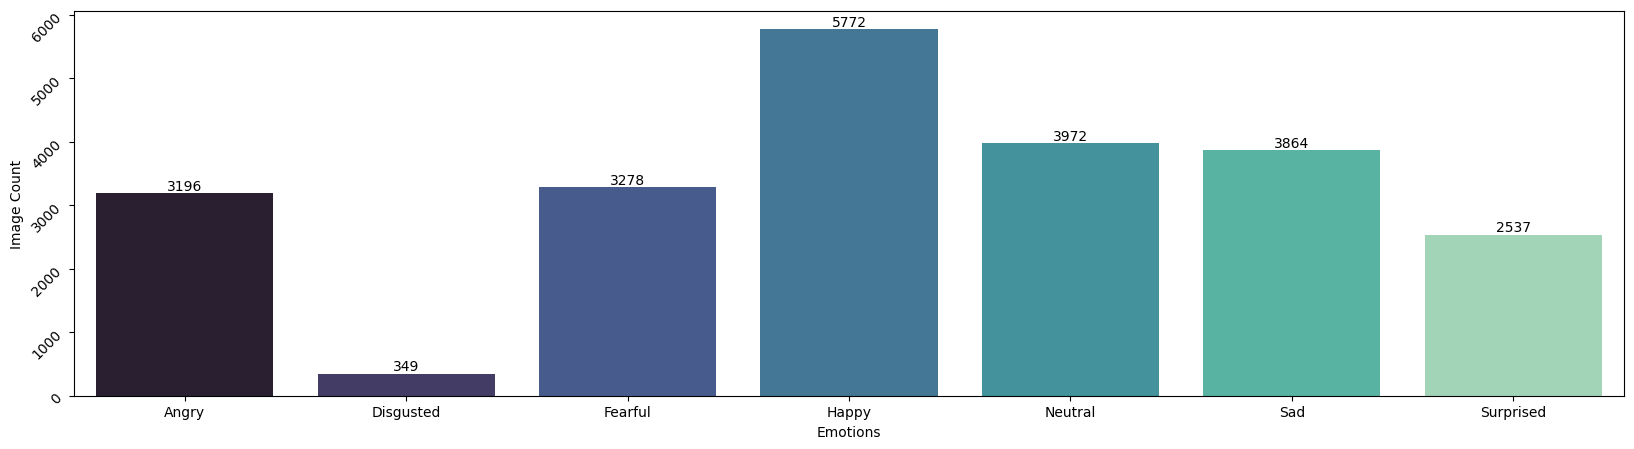

In [18]:
plt.figure(figsize=(20,5))
fig = sns.barplot(x=class_labels, 
                  y=[list(train_ds.classes).count(i) for i in np.unique(train_ds.classes)], 
                  palette="mako")
fig.set(xlabel="Emotions", ylabel="Image Count")

for i in fig.containers:
    fig.bar_label(i,)

plt.yticks(rotation=45)
plt.show()

## 03 - Model Definition

In [19]:
# clear session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [20]:
# Define the input shape and number of classes for your dataset
input_shape = (48, 48, 3)
num_classes = 7

In [21]:
model= tf.keras.models.Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape))
model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
    
model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten()) 
model.add(Dense(256,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
    
model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
  )

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       2

In [23]:
history = model.fit(x=train_ds, epochs=30, validation_data=val_ds)

Epoch 1/30
359/359 [==============================] - 454s 1s/step - loss: 9.2687 - accuracy: 0.1969 - val_loss: 8.5019 - val_accuracy: 0.1427
Epoch 2/30
359/359 [==============================] - 277s 772ms/step - loss: 8.2134 - accuracy: 0.2365 - val_loss: 7.7091 - val_accuracy: 0.2472
Epoch 3/30
359/359 [==============================] - 277s 773ms/step - loss: 7.1924 - accuracy: 0.2683 - val_loss: 6.4650 - val_accuracy: 0.3304
Epoch 4/30
359/359 [==============================] - 278s 775ms/step - loss: 6.2207 - accuracy: 0.3019 - val_loss: 5.5897 - val_accuracy: 0.3573
Epoch 5/30
359/359 [==============================] - 276s 769ms/step - loss: 5.3755 - accuracy: 0.3245 - val_loss: 4.8792 - val_accuracy: 0.3684
Epoch 6/30
359/359 [==============================] - 277s 770ms/step - loss: 4.6396 - accuracy: 0.3521 - val_loss: 4.3289 - val_accuracy: 0.3543
Epoch 7/30
359/359 [==============================] - 277s 770ms/step - loss: 4.0315 - accuracy: 0.3774 - val_loss: 3.5713 - va